In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [27]:
# read the dataset
df = pd.read_csv('fake_job_postings.csv')

# Drop rows where 'description' is missing since it's our main text feature
df = df.dropna(subset=['description'])

# Target and features
y = df['fraudulent']
X = df.drop(columns=['fraudulent', 'job_id'])

# Define column groups
text_features = ['description']
numeric_features = ['telecommuting', 'has_company_logo', 'has_questions']
categorical_features = ['employment_type', 'required_experience', 'required_education', 'industry']

In [28]:
# Define preprocessing steps
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=500, stop_words='english', lowercase=True))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine all transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'description'),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

In [29]:
# Define models
logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42))
])

# Define XGBoost pipeline
xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
                                 use_label_encoder=False, eval_metric='logloss',
                                 random_state=42))
])

In [30]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [31]:
# Train models - logistic regression
logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=500,
                                                                                   stop_words='english'))]),
                                                  'description'),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['telecommuting',
                                                   'has_company_logo',
                                                   'has_questions']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['employment_type',
                                                   'required_experience',
                                                   'required_education',
                                                   'industry'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [32]:
# Train models - random forest
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=500,
                                                                                   stop_words='english'))]),
                                                  'description'),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['telecommuting',
                                                   'has_company_logo',
                                                   'has_questions']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['employment_type',
                                                   'required_experience',
                                                   'required_education',
                                                   'industry'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [33]:
# Train XGBoost model
xgb.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:55:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=500,
                                                                                   stop_words='english'))]),
                                                  'description'),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['telecommuting',
                                                   'has_company_logo',
                                                   'has_questions']),
                                                 ('cat',
                                                  Pipeline(steps...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [35]:
# Predictions and Evaluation
models = {'Logistic Regression': logreg, 'Random Forest': rf, 'XGBoost': xgb}
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_proba),
        'fpr': roc_curve(y_test, y_proba)[0],
        'tpr': roc_curve(y_test, y_proba)[1]
    }

# Return key metrics
results_summary = {model: {k: round(v, 3) for k, v in metrics.items() if k in ['accuracy', 'f1', 'auc']} for model, metrics in results.items()}
results_summary

{'Logistic Regression': {'accuracy': 0.902,
  'f1': 0.463,
  'auc': np.float64(0.952)},
 'Random Forest': {'accuracy': 0.978, 'f1': 0.708, 'auc': np.float64(0.98)},
 'XGBoost': {'accuracy': 0.973, 'f1': 0.726, 'auc': np.float64(0.963)}}

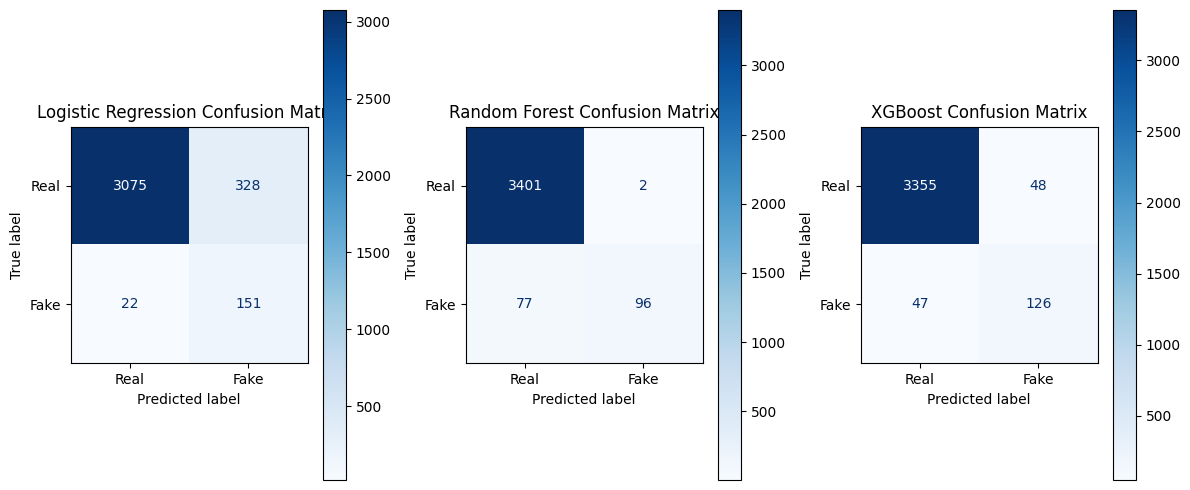

In [39]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f"{name} Confusion Matrix")

plt.tight_layout()
plt.show()


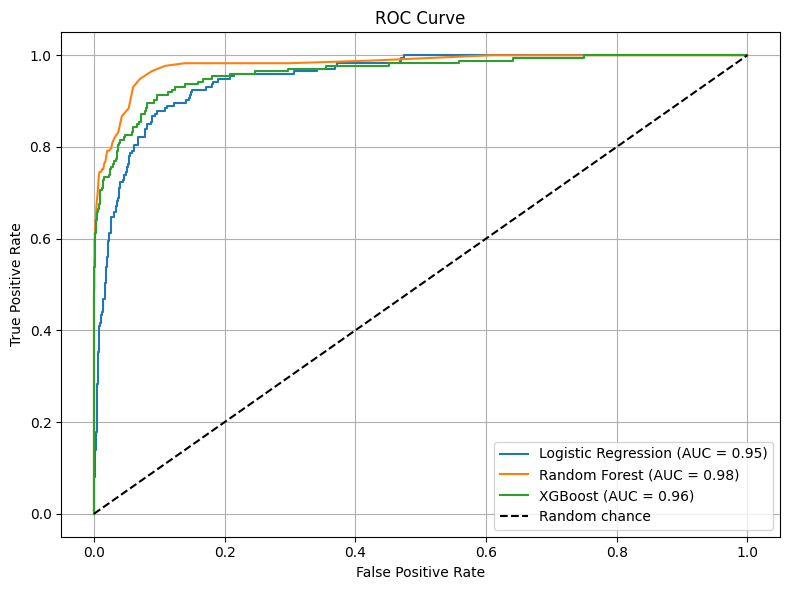

In [40]:
# Plot ROC curves
plt.figure(figsize=(8, 6))
for name in results:
    plt.plot(results[name]['fpr'], results[name]['tpr'], label=f"{name} (AUC = {results[name]['auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
